Phase 1: Fit model with autonomous growth rate functions to data from late experimental time points.

The nondimensional equations are 
$$\begin{align*}
    \frac{dc_m}{d\tau}&=\gamma_m(y_m)c_m-\delta(c_m, y_a, y_m)c_m\\
    \frac{dy_a}{d\tau}&=\beta_ac_m-\eta_a\gamma_a(y_a)(1-c_m)-\delta(c_m, y_a, y_m)(y_a-\alpha)\\
    \frac{dy_m}{d\tau}&=\beta_m(1-c_m)-\eta_m\gamma_m(y_m)c_m-\delta(c_m, y_a, y_m)(y_m-\mu)
\end{align*}$$
where
$\gamma'_a(y_a)=\frac{y_a^{b_a}}{K^{b_a}+y_a^{b_a}}$ and $\gamma'_m(y_m)=\frac{\gamma y_m^{b_m}}{1+y_m^{b_m}}$ and $\delta(c_m, y_a, y_m)=\gamma_a(y_a)(1-c_m)+\gamma_m(y_m)c_m$.
We scaled the cell equations by $C$ and $\gamma_{a,max}$, and the metabolite equations by $K_m$ and $\gamma_{a,max}$ to nondimensionalize.
The nondimensional parameters are
$$\begin{align*}
\gamma&=\frac{\gamma_{m,max}}{\gamma_{a,max}}\\
K&=\frac{K_a}{K_m}\\
b_{a,m}& \text{ unchanged}\\
\beta'_{a,m}&=\frac{\beta_{a,m}C}{\gamma_{a,max}K_m}\\
\eta'_{a,m}&=\frac{\eta_{a,m}C}{K_m}
\end{align*}$$
Fit the 4 unique steady state ratio datasets at once excluding dynamic phase time points. We will use the results from this fit in phase 2 to parameterize the nonautonomous  model.


In [1]:
import numpy as np
from scipy.integrate import odeint #For ODE integration
import matplotlib.pyplot as plt #For plotting
#import seaborn as sns 
import pymc as pm
from pymc.ode import DifferentialEquation
import arviz as az

In [2]:
# Set parameter for nondimensionalizing time and concentration later on
gammaamax=2.3
km=.006


Load experimental data from excel file:

In [3]:
import pandas as pd
file_name =  '/Users/amanda/Documents/MATLAB/auxotroph_ratio_control_summary.xlsx' # path to file + file name

#Define function that loads data from each experiment and returns a vector of t values and a vector of r values
def loadData(sheet1, sheet2, sheet3):
    
    df1 = pd.read_excel(io=file_name, sheet_name=sheet1)
    df2 = pd.read_excel(io=file_name, sheet_name=sheet2)
    df3 = pd.read_excel(io=file_name, sheet_name=sheet3)

    combined_df = pd.concat([df1,df2,df3], ignore_index=True)

    combined_df_sorted = combined_df.sort_values(by='Time')

    data=combined_df_sorted.to_numpy()
    lb_avg=(data[:,1]+data[:,2]+data[:,3])/3
    m_avg=(data[:,4]+data[:,5]+data[:,6])/3
    rdata=m_avg/lb_avg
    # Replace entries greater than 1 with 1
    rdata[rdata > 1] = 1
    
    #rescale time by \gamma_{a,max}
    tdata = data[:,0]/60/60*gammaamax

    return tdata, rdata


In [ ]:
tdata_unsupp50,rdata_unsupp50=loadData('metAargC-1','metAargC-2','metAargC-3')
tdata_unsupp99,rdata_unsupp99=loadData('metAargC-99-1-1','metAargC-99-1-2','metAargC-99-1-3')
tdata_unsupp1,rdata_unsupp1=loadData('metAargC-1-99-1','metAargC-1-99-2','metAargC-1-99-3')
tdata1_1,rdata1_1=loadData('metAargC-1uMargmet-1','metAargC-1uMargmet-2','metAargC-1uMargmet-3')
tdata10_10,rdata10_10=loadData('metAargC-10uMarg-10nMmet-1','metAargC-10uMarg-10nMmet-2','metAargC-10uMarg-10nMmet-3')
tdata10_5,rdata10_5=loadData('metAargC-10uMarg-5nMmet-1','metAargC-10uMarg-5nMmet-2','metAargC-10uMarg-5nMmet-3')


# Use only data from times greater than \tau = 40
early=40
f_tdata_unsupp50=tdata_unsupp50[tdata_unsupp50 >= early]
f_rdata_unsupp50=rdata_unsupp50[(len(tdata_unsupp50)-len(f_tdata_unsupp50)):]

f_tdata1_1=tdata1_1[tdata1_1 >= early]
f_rdata1_1=rdata1_1[(len(tdata1_1)-len(f_tdata1_1)):]

f_tdata10_10=tdata10_10[tdata10_10 >= early]
f_rdata10_10=rdata10_10[(len(tdata10_10)-len(f_tdata10_10)):]

f_tdata10_5=tdata10_5[tdata10_5 >= early]
f_rdata10_5=rdata10_5[(len(tdata10_5)-len(f_tdata10_5)):]



Define ODE models to use in PyMC

In [48]:
#Define the ODE system in the following function

def KmAuxRatio_unsupp(x, t, p):
    #Unpack state variables
    
    cm=x[0]
    ya=x[1]
    ym=x[2]
    
    #Unpack unknown params
    baprime=p[0]
    bmprime=p[1]
    etaaprime=p[2]
    etamprime=p[3]
    gamma=p[4]
    K=p[5]
    ba=p[6]
    bm=p[7]
    
    alpha=0/km #no supplemented Arg
    m=0/km
    ## Model
    dcmdt=(gamma * ym**bm) / (1 + ym**bm)*cm-((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))*cm
    dyadt = baprime * cm - etaaprime * ((ya**ba) / (K**ba + ya**ba)) *(1-cm) -((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))* (ya-alpha)
    dymdt = bmprime * (1-cm) - etamprime * (gamma * ym**bm) / (1 + ym**bm) * cm -((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))* (ym-m)

    return dcmdt,dyadt,dymdt



def KmAuxRatio1_1(x, t, p):
    #Unpack state variables
    
    cm=x[0]
    ya=x[1]
    ym=x[2]
    #Unpack unknown params
    baprime=p[0]
    bmprime=p[1]
    etaaprime=p[2]
    etamprime=p[3]
    gamma=p[4]
    K=p[5]
    ba=p[6]
    bm=p[7]
    
    
    alpha=1/km #1\mu M supplemented Arg
    m=1/km
    
    ## Model
    dcmdt=(gamma * ym**bm) / (1 + ym**bm)*cm-((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))*cm
    dyadt = baprime * cm - etaaprime * ((ya**ba) / (K**ba + ya**ba)) *(1-cm) -((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))* (ya-alpha)
    dymdt = bmprime * (1-cm) - etamprime * (gamma * ym**bm) / (1 + ym**bm) * cm -((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))* (ym-m)

    
    return dcmdt,dyadt,dymdt

def KmAuxRatio10_10(x, t, p):
    #Unpack state variables 
    cm=x[0]
    ya=x[1]
    ym=x[2]
    #Unpack unknown params
    baprime=p[0]
    bmprime=p[1]
    etaaprime=p[2]
    etamprime=p[3]
    gamma=p[4]
    K=p[5]
    ba=p[6]
    bm=p[7]
    
    
    alpha=10/km 
    m=0.01/(km)
    
    ## Model
    dcmdt=(gamma * ym**bm) / (1 + ym**bm)*cm-((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))*cm
    dyadt = baprime * cm - etaaprime * ((ya**ba) / (K**ba + ya**ba)) *(1-cm) -((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))* (ya-alpha)
    dymdt = bmprime * (1-cm) - etamprime * (gamma * ym**bm) / (1 + ym**bm) * cm -((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))* (ym-m)

    return dcmdt,dyadt,dymdt

def KmAuxRatio10_5(x, t, p):
    #Unpack state variables
    
    cm=x[0]
    ya=x[1]
    ym=x[2]
    #Unpack unknown params
    baprime=p[0]
    bmprime=p[1]
    etaaprime=p[2]
    etamprime=p[3]
    gamma=p[4]
    K=p[5]
    ba=p[6]
    bm=p[7]
    
    
    alpha=10/km #no supplemented Arg
    
    m=0.005/km
    
    ## Model
    dcmdt=(gamma * ym**bm) / (1 + ym**bm)*cm-((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))*cm
    dyadt = baprime * cm - etaaprime * ((ya**ba) / (K**ba + ya**ba)) *(1-cm) -((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))* (ya-alpha)
    dymdt = bmprime * (1-cm) - etamprime * (gamma * ym**bm) / (1 + ym**bm) * cm -((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))* (ym-m)

    
    return dcmdt,dyadt,dymdt




In [7]:
t0=0 #initial time

x_0_unsupp50 = [.5,0,0]#[cm_initial,ya_initial,ym_initial] 
x_0_1_1 = [.5,1/km,1/km]
x_0_10_10 = [.5,10/km,.01/km]
x_0_10_5 = [.5,10/km,.005/km]


ode_model_unsupp50 = DifferentialEquation(func=KmAuxRatio_unsupp, times=f_tdata_unsupp50, n_states=3, n_theta=8, t0=t0)
ode_model1_1 = DifferentialEquation(func=KmAuxRatio1_1, times=f_tdata1_1, n_states=3, n_theta=8, t0=t0)
ode_model10_10 = DifferentialEquation(func=KmAuxRatio10_10, times=f_tdata10_10, n_states=3, n_theta=8, t0=t0)
ode_model10_5 = DifferentialEquation(func=KmAuxRatio10_5, times=f_tdata10_5, n_states=3, n_theta=8, t0=t0)





Use DEMetropolisZ to fit model to data

In [35]:
with pm.Model() as model:
    # Specify prior distributions for our model parameters

    baprime=pm.Gamma('baprime', mu=100,sigma=50)
    bmprime=pm.Gamma('bmprime', mu=1,sigma=1)
    etaaprime=pm.Gamma('etaaprime', mu=.1,sigma=.2)
    etamprime=pm.Gamma('etamprime', mu=.1,sigma=.2)
    gamma=pm.Uniform('gamma', lower=.5,upper=2)
    K=pm.Gamma('K', mu=700, sigma=250)
    ba=pm.Uniform('ba', lower=.5,upper=10)
    bm=pm.Uniform('bm', lower=.5,upper=10)

    # Specifiy prior distribution for observational noise
    sigma = pm.HalfNormal('sigma', 1)

    ode_solution_unsupp50 = ode_model_unsupp50(y0=x_0_unsupp50, theta=[baprime, bmprime,etaaprime,etamprime,gamma,K,ba,bm])
    ode_solution1_1 = ode_model1_1(y0=x_0_1_1, theta=[baprime, bmprime,etaaprime,etamprime,gamma,K,ba,bm])
    ode_solution10_10 = ode_model10_10(y0=x_0_10_10, theta=[baprime, bmprime,etaaprime,etamprime,gamma,K,ba,bm])
    ode_solution10_5 = ode_model10_5(y0=x_0_10_5, theta=[baprime, bmprime,etaaprime,etamprime,gamma,K,ba,bm])

    #Define likelihood
    Y1 = pm.Normal("Y1", mu=ode_solution_unsupp50[:,0], sigma=sigma, observed=f_rdata_unsupp50)
    Y2 = pm.Normal("Y2", mu=ode_solution1_1[:,0], sigma=sigma, observed=f_rdata1_1)
    Y3 = pm.Normal("Y3", mu=ode_solution10_10[:,0], sigma=sigma, observed=f_rdata10_10)
    Y4 = pm.Normal("Y4", mu=ode_solution10_5[:,0], sigma=sigma, observed=f_rdata10_5)

    # Set custom initial values
    initvals = {"baprime": 70,"bmprime":1.5,"etaaprime":0.01,"etamprime":0.01,"gamma":1.05, "K":115, "ba":9, "bm":5, "sigma": 0.1}
    
    # Use Metropolis-Hastings sampler
    step = pm.DEMetropolisZ()

    trace=pm.sample(tune=6000, draws=6000, initvals=initvals, step=step)

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [baprime, bmprime, etaaprime, etamprime, gamma, K, ba, bm, sigma]


Sampling 4 chains for 6_000 tune and 6_000 draw iterations (24_000 + 24_000 draws total) took 6296 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


View posterior

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
baprime     73.595  11.214   51.357   93.942      0.836    0.592   180.973   
bmprime      1.294   0.113    1.077    1.489      0.016    0.011    57.399   
etaaprime    0.118   0.208    0.000    0.462      0.009    0.006   280.099   
etamprime    0.048   0.072    0.000    0.204      0.006    0.004   119.038   
gamma        1.014   0.005    1.006    1.022      0.001    0.001    30.240   
K          130.502  11.239  109.511  150.124      0.707    0.501   281.175   
ba           9.039   0.725    7.689    9.997      0.043    0.031   249.077   
bm           5.846   0.761    4.678    7.338      0.148    0.107    28.208   

           ess_tail  r_hat  
baprime     288.351  1.023  
bmprime      90.504  1.065  
etaaprime   323.900  1.026  
etamprime   206.472  1.053  
gamma        71.189  1.099  
K           279.918  1.013  
ba          216.058  1.027  
bm           62.755  1.106

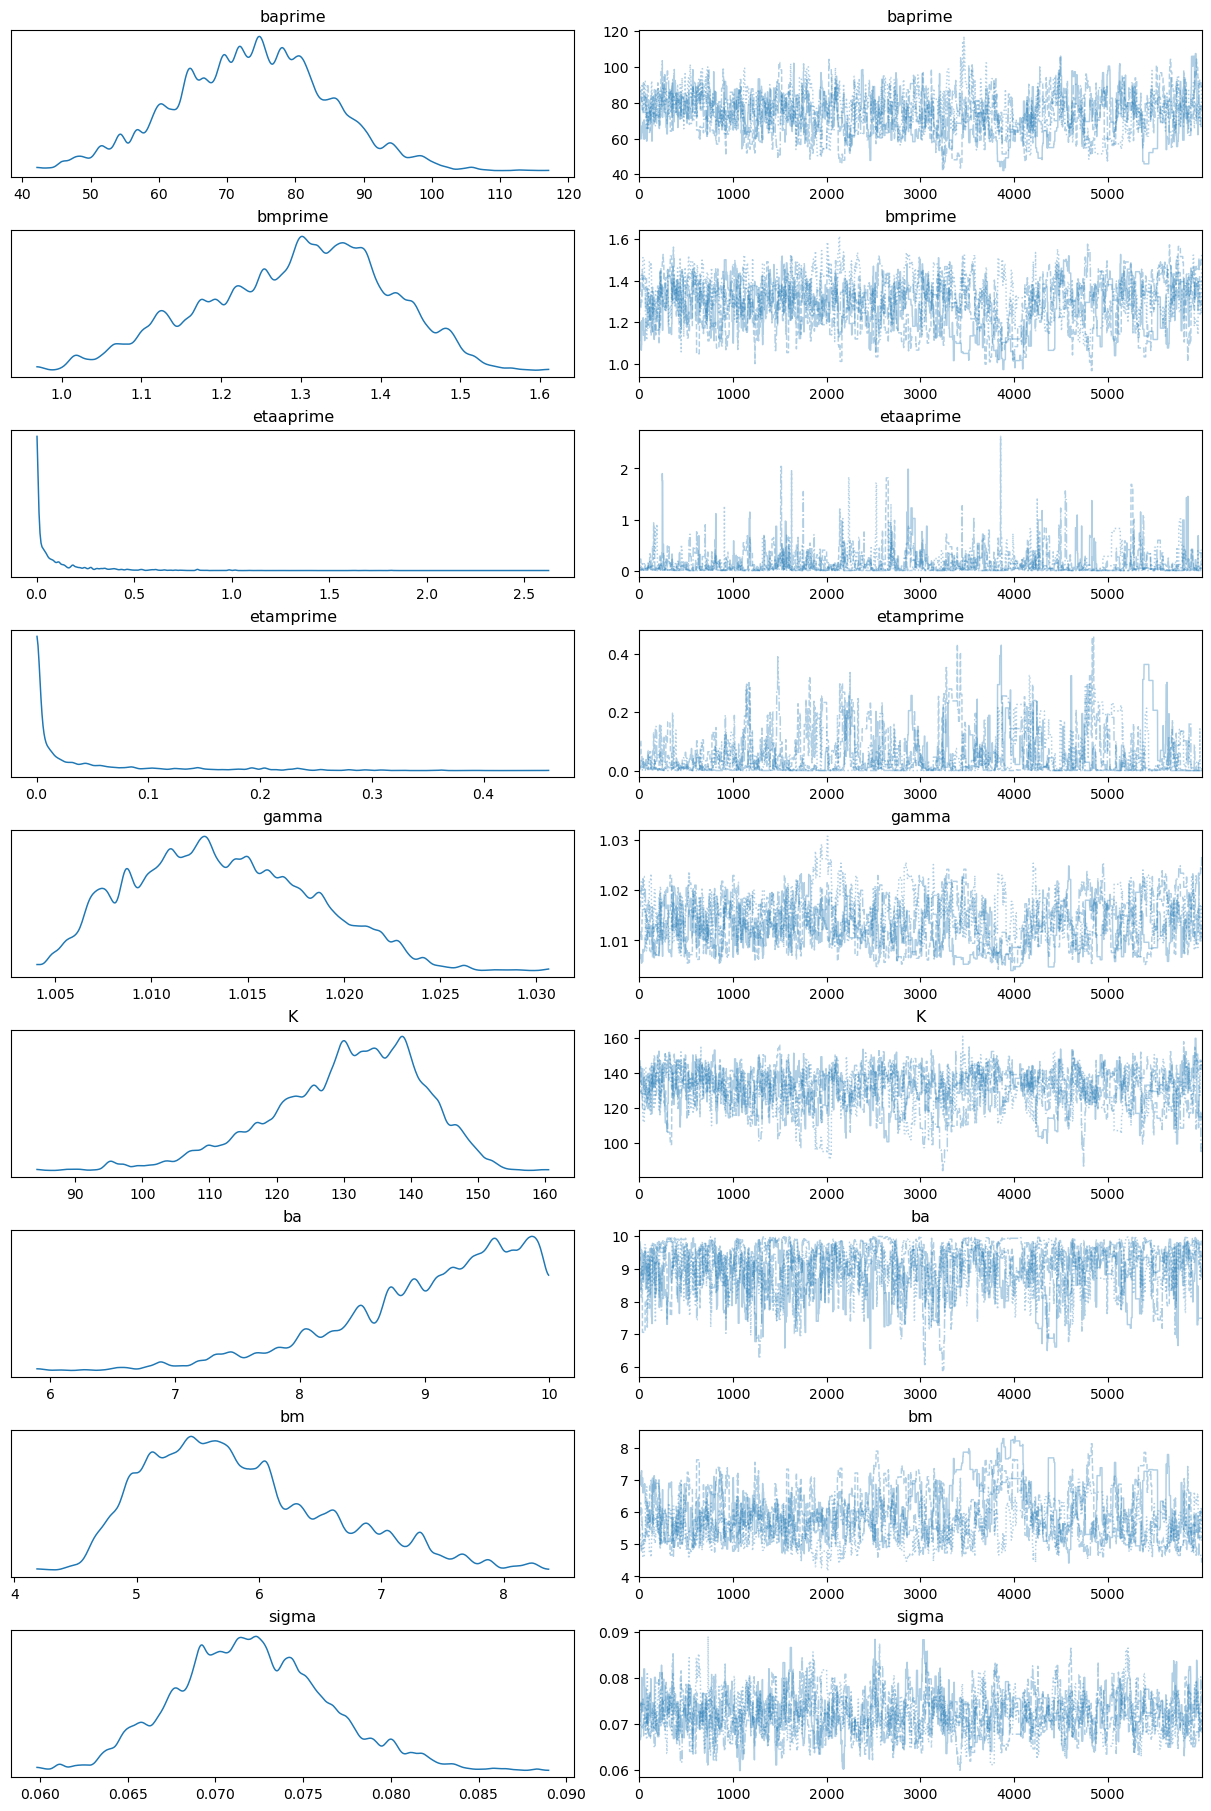

In [36]:
plt.rcParams['figure.constrained_layout.use'] = True
az.plot_trace(trace,combined=True);
az.summary(trace, var_names=["baprime","bmprime","etaaprime","etamprime","gamma", "K", "ba", "bm"], round_to=3)


/Users/amanda/miniforge3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/pairplot.py:232: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  gridsize = int(dataset.dims["draw"] ** 0.35)


array([[<Axes: ylabel='baprime'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='bmprime'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='etaaprime'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='etamprime'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='gamma'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='K'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='ba'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='baprime', ylabel='bm'>, <Axes: xlabel='bmprime'>,
        <Axes: xlabel='etaaprime'>, <Axes: xlabel='etamprime'>,
        <Axes: xlabel='gamma'>, <Axes: xlabel='K'>, <Axes: xlabel='ba'>,
        

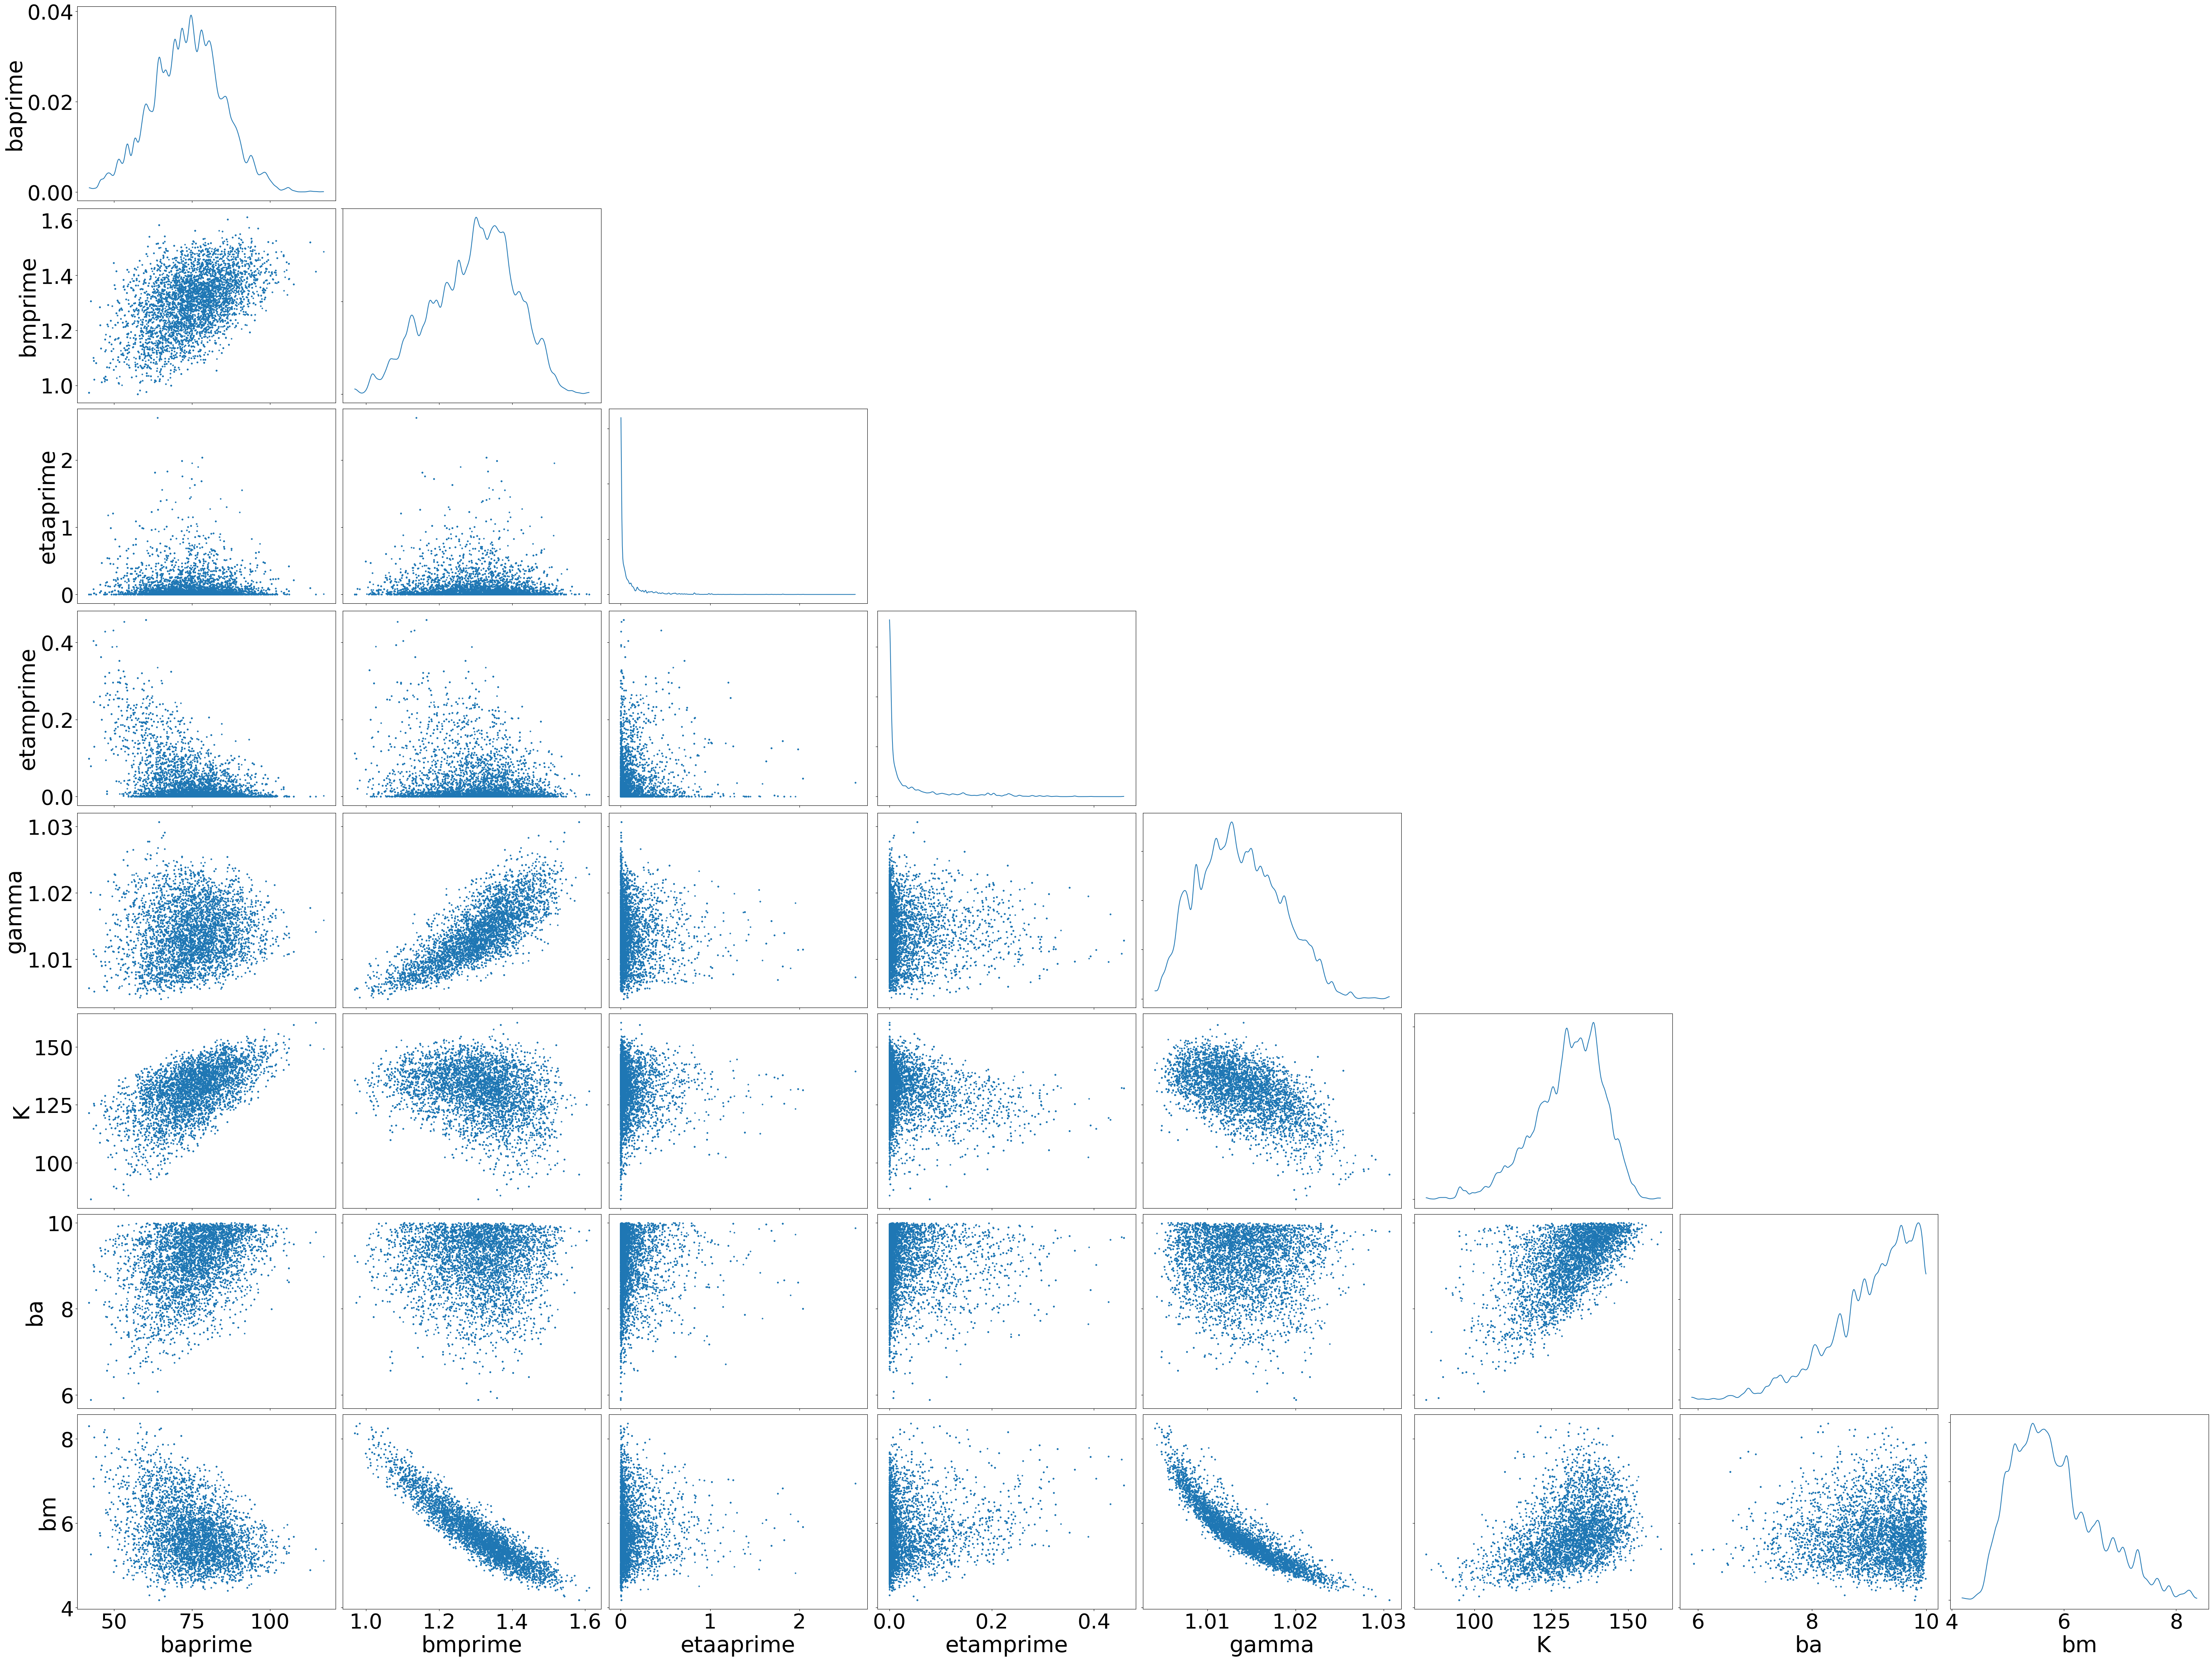

In [38]:
# Use Arviz to look at correlations

az.plot_pair(trace, var_names=['baprime','bmprime','etaaprime','etamprime','gamma','K','ba','bm'], marginals=True,textsize=40)


array([[<Axes: title={'center': 'baprime'}>,
        <Axes: title={'center': 'baprime'}>],
       [<Axes: title={'center': 'bmprime'}>,
        <Axes: title={'center': 'bmprime'}>],
       [<Axes: title={'center': 'etaaprime'}>,
        <Axes: title={'center': 'etaaprime'}>],
       [<Axes: title={'center': 'etamprime'}>,
        <Axes: title={'center': 'etamprime'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'K'}>, <Axes: title={'center': 'K'}>],
       [<Axes: title={'center': 'ba'}>, <Axes: title={'center': 'ba'}>],
       [<Axes: title={'center': 'bm'}>, <Axes: title={'center': 'bm'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

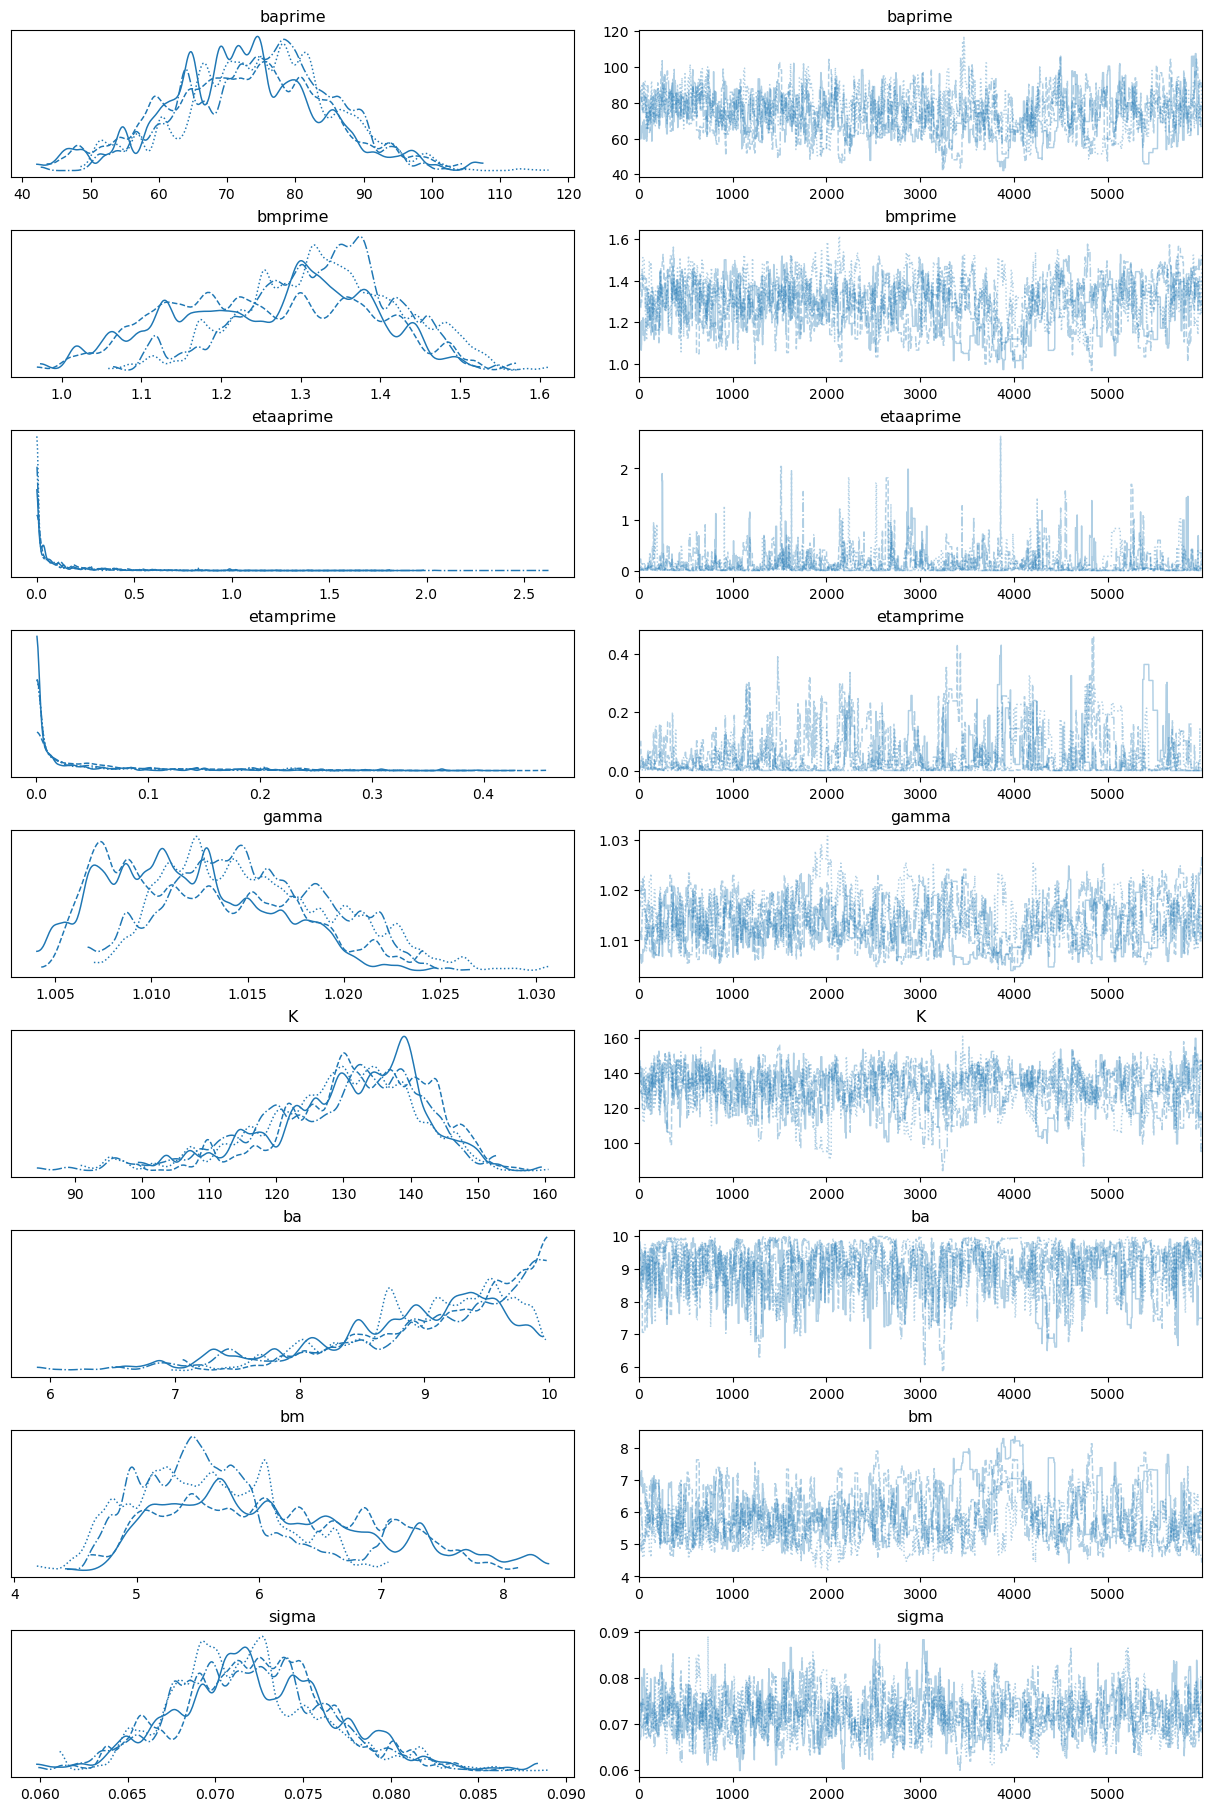

In [39]:
az.plot_trace(trace)